# Predictors of Pregnancy Risks
Our research aims to identify the key indicators that influence risk levels during pregnancy. We are using a dataset taken from various hospitals, clinics and maternal health care centers in Bangladesh, India. Our primary focus is analyzing age, blood pressure, heart rate, and blood sugar to determine their impact on predicted risk intensity level of pregnancy complications.

Our study found blood pressure to be the strongest indicator of pregnancy risks, surpassing age, heart rate, and blood sugar. The importance of managing blood pressure is shown by our significant findings, with a p-value of 1.39e-23, indicating a strong relationship between blood pressure and pregnancy risk levels. Overall, this highlights the necessity of prioritizing blood pressure monitoring to ensure the safety of both the mother and child during pregnancy.

In [63]:
# Dependencies and Setup
%matplotlib inline

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress, pearsonr
import numpy as np
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from api_keys import geoapify_key
import requests
import json
import hvplot.pandas

In [64]:
# Specifying path to CSV file
file_path = 'C:\\Users\\lnata\\GitHub\\Project1group3\\Resources\\maternal_health.csv'

# Read the .csv file
maternal_health = pd.read_csv(file_path)

In [65]:
# Print DataFrame
maternal_health.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [66]:
# Count each risk level (low, mid, high)
risk_level_counts = maternal_health["RiskLevel"].value_counts()

# Print
risk_level_counts

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64

In [67]:
# Dropping duplicate data
maternal_df = maternal_health.drop_duplicates(subset=None, keep='first', inplace=False)
maternal_df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
673,12,100,50,6.4,98.0,70,mid risk
674,15,100,60,6.0,98.0,80,low risk
703,15,100,49,7.6,98.0,77,low risk
704,12,100,50,6.0,98.0,70,mid risk


In [68]:
# Count each risk level after cleaning data
clean = maternal_df["RiskLevel"].value_counts()
clean

RiskLevel
low risk     234
high risk    112
mid risk     106
Name: count, dtype: int64

In [69]:
# Adding a new column 'Woman_ID' with unique identifiers starting from 1
maternal_health['Woman_ID'] = range(1, len(maternal_health) + 1)

# Reordering the DataFrame columns
columns = ['Woman_ID'] + [col for col in maternal_health.columns if col != 'Woman_ID']
maternal_health = maternal_health[columns]

# Print
maternal_health.head()

,Woman_ID,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,1,25,130,80,15.0,98.0,86,high risk
1,2,35,140,90,13.0,98.0,70,high risk
2,3,29,90,70,8.0,100.0,80,high risk
3,4,30,140,85,7.0,98.0,70,high risk
4,5,35,120,60,6.1,98.0,76,low risk


In [70]:
# Renaming columns for better understanding
maternal_renamed = maternal_health.rename(columns={"Woman_ID":"Woman ID", "BS":"Blood Sugar", "SystolicBP":"Systolic Blood Pressure", 
                                                   "DiastolicBP":"Diastolic Blood Pressure", "BodyTemp":"Body Temp.", 
                                                   "HeartRate":"Heart Rate", "RiskLevel":"Risk Level"})
maternal_renamed.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Sugar,Body Temp.,Heart Rate,Risk Level
0,1,25,130,80,15.0,98.0,86,high risk
1,2,35,140,90,13.0,98.0,70,high risk
2,3,29,90,70,8.0,100.0,80,high risk
3,4,30,140,85,7.0,98.0,70,high risk
4,5,35,120,60,6.1,98.0,76,low risk


In [71]:
# Create a new column "Blood Pressure" by combining "Systolic Blood Pressure" and "Diastolic Blood Pressure"
maternal_renamed.loc[:, 'Blood Pressure'] = maternal_renamed['Systolic Blood Pressure'].astype(str) + '/' + maternal_renamed['Diastolic Blood Pressure'].astype(str)
column_to_move = maternal_renamed.pop('Blood Pressure')
maternal_renamed.insert(4, 'Blood Pressure', column_to_move)

# Print
maternal_renamed.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Pressure,Blood Sugar,Body Temp.,Heart Rate,Risk Level
0,1,25,130,80,130/80,15.0,98.0,86,high risk
1,2,35,140,90,140/90,13.0,98.0,70,high risk
2,3,29,90,70,90/70,8.0,100.0,80,high risk
3,4,30,140,85,140/85,7.0,98.0,70,high risk
4,5,35,120,60,120/60,6.1,98.0,76,low risk


# Blood Pressure VS Risk Level
## Hypothesis:
Women who have high blood pressure are at a higher risk than women who are within the normal blood pressure range.

In [72]:
maternal_bp = maternal_renamed[['Woman ID', 'Age', "Systolic Blood Pressure", "Diastolic Blood Pressure", "Blood Pressure"]].copy()
maternal_bp.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Pressure
0,1,25,130,80,130/80
1,2,35,140,90,140/90
2,3,29,90,70,90/70
3,4,30,140,85,140/85
4,5,35,120,60,120/60


In [73]:
# Define bins for Systolic BP
systolic_bins = [0, 119, 129, max(maternal_bp['Systolic Blood Pressure'])+1]
systolic_labels = ["Normal", "Elevated", "High"]

# Create a copy of the DataFrame to avoid modifying the original data
sys_categorized = maternal_bp.copy()

# Use `pd.cut` to categorize Systolic BP
sys_categorized['Systolic BP Category'] = pd.cut(sys_categorized['Systolic Blood Pressure'], bins=systolic_bins, labels=systolic_labels, include_lowest=True)

sys_categorized.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Pressure,Systolic BP Category
0,1,25,130,80,130/80,High
1,2,35,140,90,140/90,High
2,3,29,90,70,90/70,Normal
3,4,30,140,85,140/85,High
4,5,35,120,60,120/60,Elevated


In [74]:
# Define bins for Diastolic BP
diastolic_bins = [0, 79, 89, max(maternal_bp['Diastolic Blood Pressure'])+1]
diastolic_labels = ["Normal", "Elevated", "High"]

# Create a copy of DF above to include Systolic range
dias_categorized = sys_categorized.copy()

# Use `pd.cut` to categorize Diastolic BP
dias_categorized['Diastolic BP Category'] = pd.cut(dias_categorized['Diastolic Blood Pressure'], bins=diastolic_bins, labels=diastolic_labels, include_lowest=True)

dias_categorized.head()

,Woman ID,Age,Systolic Blood Pressure,Diastolic Blood Pressure,Blood Pressure,Systolic BP Category,Diastolic BP Category
0,1,25,130,80,130/80,High,Elevated
1,2,35,140,90,140/90,High,High
2,3,29,90,70,90/70,Normal,Normal
3,4,30,140,85,140/85,High,Elevated
4,5,35,120,60,120/60,Elevated,Normal


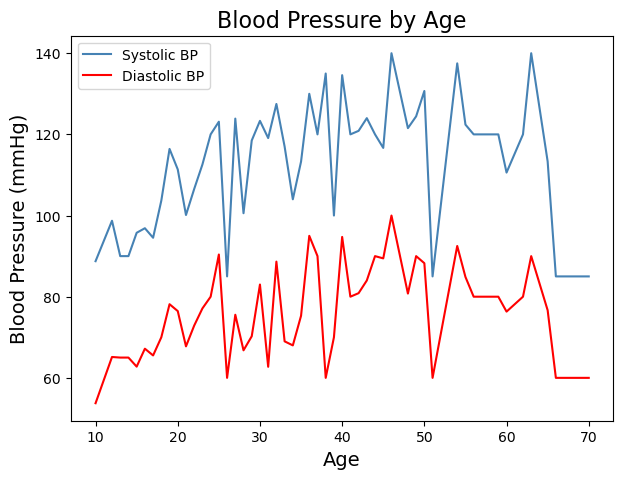

In [75]:
# Generate a line plot for BP
grouped_bp = maternal_bp.groupby('Age')[['Systolic Blood Pressure', 'Diastolic Blood Pressure']].mean()

# Plotting data
plt.figure(figsize=(7, 5))
plt.plot(grouped_bp['Systolic Blood Pressure'], linestyle='-', color='steelblue', label='Systolic BP')
plt.plot(grouped_bp['Diastolic Blood Pressure'], linestyle='-', color='red', label='Diastolic BP')

# Labeling 
plt.xlabel('Age', fontsize=14)
plt.ylabel('Blood Pressure (mmHg)', fontsize=14)
plt.title('Blood Pressure by Age', fontsize=16)
plt.legend()

# Print
plt.savefig("C:/Users/lnata/Github/Project1group3/Output-Data\Fig1.png",bbox_inches='tight')
plt.show()

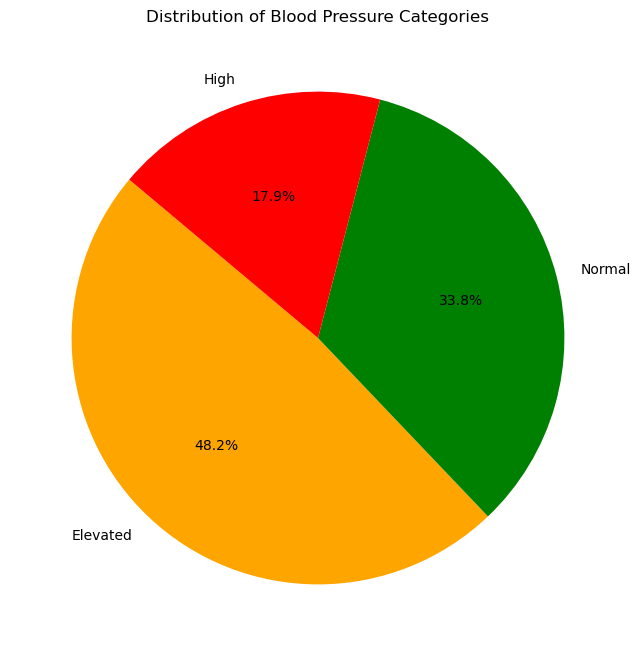

In [76]:
# Creating a pie chart distributing blood pressure categories
def categorize_bp(row):
    if row['Systolic Blood Pressure'] < 120 and row['Diastolic Blood Pressure'] < 80:
        return 'Normal'
    elif (120 <= row['Systolic Blood Pressure'] < 130) or (80 <= row['Diastolic Blood Pressure'] < 89):
        return 'Elevated'
    else:
        return 'High'

maternal_bp['BP_Category'] = maternal_bp.apply(categorize_bp, axis=1)
category_counts = maternal_bp['BP_Category'].value_counts()

# Ploting pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=['orange', 'green', 'red'])
plt.title('Distribution of Blood Pressure Categories')

# Print
plt.savefig("C:/Users/lnata/Github/Project1group3/Output-Data\Fig2.png",bbox_inches='tight')
plt.show()

In [77]:
stats.ttest_ind(grouped_bp["Systolic Blood Pressure"], grouped_bp["Diastolic Blood Pressure"], equal_var=False)

TtestResult(statistic=13.599127751943174, pvalue=1.3950072797968633e-23, df=90.39197000659932)

<span style="color:green"> The result of the pvalue was "0.00000000000000000000000636572839949892", therefore it is significant. </span>

# Blood Sugar VS Risk Level
## Hypothesis
Elevated blood glucose levels in pregnant women are associated with an increased risk of complications, categorizing the pregnancy as higher risk

In [78]:
maternal_bs = maternal_renamed[['Woman ID', 'Age', "Blood Sugar",]].copy()
maternal_bs.head()

,Woman ID,Age,Blood Sugar
0,1,25,15.0
1,2,35,13.0
2,3,29,8.0
3,4,30,7.0
4,5,35,6.1


In [79]:
# Defining Bins for Blood Sugar
bs_bins = [0, 6, 12, max(maternal_bs['Blood Sugar'])+1]
bs_labels = ["Low Risk", "Mid Risk", "High Risk"]

# Create a copy of DF above to include Blood Sugar
bs_categorized = maternal_bs.copy()

# Use `pd.cut` to categorize Blood Sugar
bs_categorized['Risk Level by Blood Sugar'] = pd.cut(bs_categorized['Blood Sugar'], bins=bs_bins, labels=bs_labels, include_lowest=True)

bs_categorized.head()

,Woman ID,Age,Blood Sugar,Risk Level by Blood Sugar
0,1,25,15.0,High Risk
1,2,35,13.0,High Risk
2,3,29,8.0,Mid Risk
3,4,30,7.0,Mid Risk
4,5,35,6.1,Mid Risk


In [80]:
# Defining Bins for Age
age_bins = [0, 20, 30, 40, 50, max(bs_categorized['Age'])+1]
age_labels = ['<20', '20-30', '31-40', '41-50', '>50']

bs_categorized['Age Group'] = pd.cut(bs_categorized['Age'], bins=age_bins, labels=age_labels, right=False)

bs_categorized.head()

,Woman ID,Age,Blood Sugar,Risk Level by Blood Sugar,Age Group
0,1,25,15.0,High Risk,20-30
1,2,35,13.0,High Risk,31-40
2,3,29,8.0,Mid Risk,20-30
3,4,30,7.0,Mid Risk,31-40
4,5,35,6.1,Mid Risk,31-40


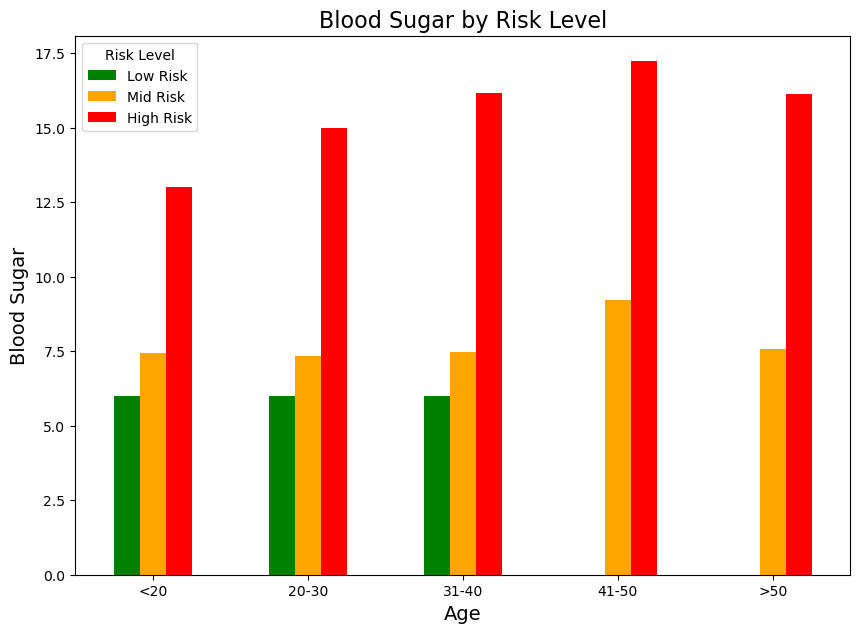

In [81]:
# Generate a bar graph for Blood Sugar
bloodsugar = bs_categorized.groupby(['Age Group', 'Risk Level by Blood Sugar'])['Blood Sugar'].mean().reset_index()

# Pivotting data to include each column
pivot_bs = bloodsugar.pivot(index='Age Group', columns='Risk Level by Blood Sugar', values='Blood Sugar')

# Plotting data
pivot_bs.plot(kind='bar', figsize=(10, 7), color= ["g", "orange", "red"])
plt.xlabel('Age', fontsize=14)
plt.ylabel('Blood Sugar', fontsize=14)
plt.title('Blood Sugar by Risk Level', fontsize=16)
plt.legend(title='Risk Level')
plt.xticks(rotation=360)

# Print
plt.savefig("C:/Users/lnata/Github/Project1group3/Output-Data\Fig3.png",bbox_inches='tight')
plt.show()

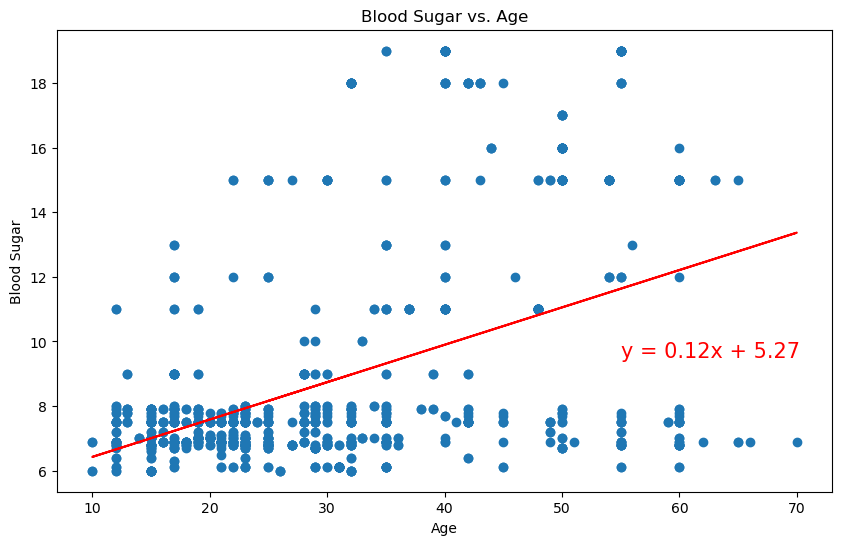

In [82]:
# Generate a Scatter Plot for Blood Sugar
from scipy.stats import linregress

# Plotting scatter plot
plt.figure(figsize=(10, 6))


# Linear Regression plotting
x_values = bs_categorized["Age"]
y_values = bs_categorized["Blood Sugar"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (55,9.5), fontsize=15, color = "red")

# Labeling
plt.title('Blood Sugar vs. Age')
plt.xlabel('Age')
plt.ylabel('Blood Sugar')

# Print
plt.savefig("C:/Users/lnata/Github/Project1group3/Output-Data\Fig4.png",bbox_inches='tight')
plt.show()

# Age VS Risk Level
## Hypothesis
The age of a woman significantly influences her risk level during pregnancy, with specific age groups showing a higher chance.

In [83]:
# Generate a summary statistics table of mean, median, variance, standard deviation, on Risk Level based on Age
summary =  maternal_renamed.groupby(['Risk Level'])[['Age']].agg(['mean', 'median', 'var', 'std', 'sem']).reset_index()

summary.columns = ['Risk Level', 'Mean', 'Median', 'Variance', 'Std. Dev.', 'SEM']

summary.round()

,Risk Level,Mean,Median,Variance,Std. Dev.,SEM
0,high risk,36.0,35.0,170.0,13.0,1.0
1,low risk,27.0,22.0,172.0,13.0,1.0
2,mid risk,28.0,25.0,158.0,13.0,1.0


In [84]:
# Found the Quartiles, Outliers
risk_levels = maternal_renamed['Risk Level'].unique()

# Initialize an empty list to hold age data for each risk level
age_boxplot = []

for risk_level in risk_levels:
    print(f"------------------------------------------------------------------------")
    print(f"Risk Level: {risk_level}")

    # Locate 'Age' values for the current 'Risk Level'
    ages = maternal_renamed[maternal_renamed['Risk Level'] == risk_level]['Age']

     # add subset 
    age_boxplot.append(ages)
    
    quartiles = ages.quantile([.25, .5, .75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    
    print(f"The upper quartile of age is: {upperq}")
    print(f"The lower quartile of age is: {lowerq}")
    print(f"The interquartile range of age is: {iqr}")
    print(f"Values below {lower_bound} could be outliers for risk level {risk_level}.")
    print(f"Values above {upper_bound} could be outliers for risk level {risk_level}.")
    print(f"------------------------------------------------------------------------")


------------------------------------------------------------------------
Risk Level: high risk
The upper quartile of age is: 48.0
The lower quartile of age is: 25.0
The interquartile range of age is: 23.0
Values below -9.5 could be outliers for risk level high risk.
Values above 82.5 could be outliers for risk level high risk.
------------------------------------------------------------------------
------------------------------------------------------------------------
Risk Level: low risk
The upper quartile of age is: 32.0
The lower quartile of age is: 17.0
The interquartile range of age is: 15.0
Values below -5.5 could be outliers for risk level low risk.
Values above 54.5 could be outliers for risk level low risk.
------------------------------------------------------------------------
------------------------------------------------------------------------
Risk Level: mid risk
The upper quartile of age is: 32.0
The lower quartile of age is: 19.0
The interquartile range of age is: 

In [85]:
print(len(age_boxplot))
print(len(risk_levels))

3
3


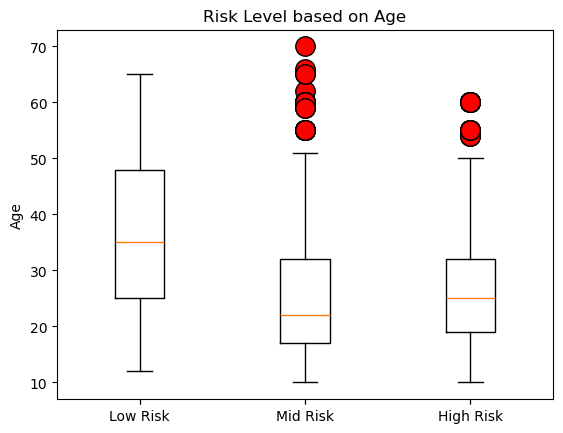

In [86]:
# Generate a boxplot

fig1, ax1 = plt.subplots()
ax1.set_title('Risk Level based on Age')
ax1.set_ylabel('Age')

# Set the locations for the x-ticks
ax1.set_xticks([1, 2, 3])

# Now, set the labels for each tick
label_risk_level = ["Low Risk", "Mid Risk", "High Risk"]
ax1.set_xticklabels(label_risk_level)

custom_color = dict(markerfacecolor="red", markersize=14)
ax1.boxplot(age_boxplot, labels=label_risk_level, flierprops=custom_color)

# Print
plt.savefig("C:/Users/lnata/Github/Project1group3/Output-Data\Fig5.png",bbox_inches='tight')
plt.show()

# Heart Rate VS Risk Level
## Hypothesis
The resting heart rate of a woman during pregnancy correlates with the risk level of the pregnancy. Certain heart rates could suggest whether her pregnancy is at a higher or lower risk.

In [87]:
maternal_hr = maternal_renamed[['Woman ID', 'Age', "Heart Rate"]].copy()
maternal_hr.head()

,Woman ID,Age,Heart Rate
0,1,25,86
1,2,35,70
2,3,29,80
3,4,30,70
4,5,35,76


In [88]:
# Defining Bins for Heart Rate
hr_bins = [50, 60, 70, 90, 110]
hr_labels = ['Low', 'Normal', 'Elevated', 'High']

# Create a copy of DF above to include Heart Rate
hr_categorized = maternal_hr.copy()

# Use `pd.cut` to categorize Heart Rate
hr_categorized['Heart Rate Category'] = pd.cut(hr_categorized['Heart Rate'], bins=hr_bins, labels=hr_labels, include_lowest=True)

hr_categorized.head()

,Woman ID,Age,Heart Rate,Heart Rate Category
0,1,25,86,Elevated
1,2,35,70,Normal
2,3,29,80,Elevated
3,4,30,70,Normal
4,5,35,76,Elevated


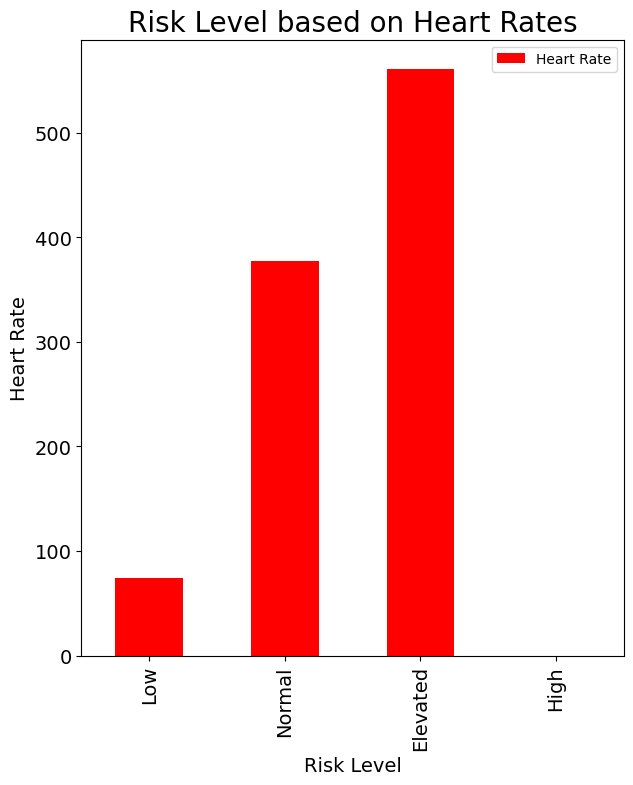

,Heart Rate
Heart Rate Category,
Low,74
Normal,377
Elevated,561
High,0


In [89]:
# Generate a bar plot for Heart Rate
hr = hr_categorized.groupby("Heart Rate Category")[["Heart Rate"]].count()
plot_pandas = hr.plot.bar(figsize=(7,8), color='r',fontsize = 14)

plt.xlabel("Risk Level",fontsize = 14)
plt.ylabel("Heart Rate",fontsize = 14)
plt.title("Risk Level based on Heart Rates",fontsize = 20)

# Print
plt.savefig("C:/Users/lnata/Github/Project1group3/Output-Data\Fig6.png",bbox_inches='tight')
plt.show()

hr

# Display Bangladesh, India on the Map

In [90]:
# Create the target city and endpoint url
target_country = "Bangladesh, India"
target_url = f"https://api.geoapify.com/v1/geocode/search?text={target_country}&format=json&apiKey={geoapify_key}"

In [91]:
# Run a request to endpoint and convert result to json
geo_data = requests.get(target_url).json()
print(geo_data)

{'results': [{'datasource': {'sourcename': 'openstreetmap', 'attribution': '© OpenStreetMap contributors', 'license': 'Open Database License', 'url': 'https://www.openstreetmap.org/copyright'}, 'name': 'Bangladesh Colony', 'ref': '160A', 'country': 'India', 'country_code': 'in', 'state': 'Kerala', 'state_district': 'Thiruvananthapuram District', 'county': 'Thiruvananthapuram', 'city': 'Thiruvananthapuram', 'postcode': '695001', 'district': 'V.V.Krishna Menon Nagar', 'suburb': 'Thiruvallam', 'street': 'Thiruvananthapuram Bypass', 'lon': 76.9304395, 'lat': 8.466881, 'state_code': 'KL', 'result_type': 'amenity', 'formatted': 'Bangladesh Colony, Thiruvananthapuram Bypass, Thiruvallam, Thiruvananthapuram - 695001, KL, India', 'address_line1': 'Bangladesh Colony', 'address_line2': 'Thiruvananthapuram Bypass, Thiruvallam, Thiruvananthapuram - 695001, KL, India', 'category': 'public_transport.bus', 'timezone': {'name': 'Asia/Kolkata', 'offset_STD': '+05:30', 'offset_STD_seconds': 19800, 'offse

In [92]:
# Print the json (pretty printed)
print(json.dumps(geo_data, indent=4, sort_keys=True))

{
    "query": {
        "parsed": {
            "city": "bangladesh",
            "country": "india",
            "expected_type": "city"
        },
        "text": "Bangladesh, India"
    },
    "results": [
        {
            "address_line1": "Bangladesh Colony",
            "address_line2": "Thiruvananthapuram Bypass, Thiruvallam, Thiruvananthapuram - 695001, KL, India",
            "bbox": {
                "lat1": 8.466831,
                "lat2": 8.466931,
                "lon1": 76.9303895,
                "lon2": 76.9304895
            },
            "category": "public_transport.bus",
            "city": "Thiruvananthapuram",
            "country": "India",
            "country_code": "in",
            "county": "Thiruvananthapuram",
            "datasource": {
                "attribution": "\u00a9 OpenStreetMap contributors",
                "license": "Open Database License",
                "sourcename": "openstreetmap",
                "url": "https://www.openstreetma

In [93]:
#Extract the Latitude and Longitude
lat = geo_data["results"][0]["lat"]
lon = geo_data["results"][0]["lon"]

#Print the result
print('''
    Country: {0}
    Latitude: {1}
    Longitude: {2}
    '''.format(target_country, lat, lon))


    Country: Bangladesh, India
    Latitude: 8.466881
    Longitude: 76.9304395
    


In [94]:
#Set the geographical coordinates for Bangladesh, India
latitude = 8.466881
longitude = 76.9304395

# Set the parameters to search for categories/conditions
categories = "healthcare.hospital"
conditions = "access"
radius = 8000

# Set the parameters for the type of search
filters = f"circle:{longitude},{latitude},{radius}"
bias = f"proximity:{longitude},{latitude}"
limit = 20

# Set up the parameters dictionary
params = {
    "categories":categories,
    "conditions":conditions,
    "limit":limit,
    "filter":filters,
    "bias":bias,
    "apiKey":geoapify_key
}

# Create the base URL, and run a request using the params dictionary
base_url = "https://api.geoapify.com/v2/places"
response = requests.get(base_url, params=params)
# Print the response url
print(response.url)
# Convert response to json and "pretty print" it
places_data = response.json()
print(json.dumps(places_data, indent=4, sort_keys=True))
print(places_data["features"][0]["properties"]["name"])
print(places_data["features"][0]["properties"]["address_line2"])
print(places_data["features"][0]["geometry"]["coordinates"])
counter = 0

for place in places_data["features"]:
    print(f"Hospital {counter+1}:")
    print(place["properties"]["name"])
    print(place["properties"]["address_line2"])
    print(places_data["features"]["geometry"]["coordinates"])
    print("*"*20)
    counter = counter + 1
    if counter == 10:
        break

https://api.geoapify.com/v2/places?categories=healthcare.hospital&conditions=access&limit=20&filter=circle%3A76.9304395%2C8.466881%2C8000&bias=proximity%3A76.9304395%2C8.466881&apiKey=a2faf3abc5fa41099a78c481c877fe34
{
    "features": [
        {
            "geometry": {
                "coordinates": [
                    76.92704744817073,
                    8.46339984939228
                ],
                "type": "Point"
            },
            "properties": {
                "address_line1": "Coastal Speciality Hospital Valiyathura",
                "address_line2": "School Road, Beemapally, Thiruvananthapuram - 695001, Kerala, India",
                "categories": [
                    "healthcare",
                    "healthcare.hospital"
                ],
                "city": "Thiruvananthapuram",
                "country": "India",
                "country_code": "in",
                "county": "Thiruvananthapuram",
                "datasource": {
                 

TypeError: list indices must be integers or slices, not str

In [95]:
# Print the results of the first 5 hospitals
counter = 0

for place in places_data["features"]:
    print(f"Hospital {counter+1}:")
    print(place["properties"]["name"])
    print(place["properties"]["address_line2"])
    print(place["geometry"]["coordinates"])
    print(place["properties"]["distance"])
    print("*"*20)
    
    counter = counter + 1
    if counter == 5:
        break

Hospital 1:
Coastal Speciality Hospital Valiyathura
School Road, Beemapally, Thiruvananthapuram - 695001, Kerala, India
[76.92704744817073, 8.46339984939228]
528
********************
Hospital 2:
Government siddha hospita lVallakkadavu
Vallakkadavu Road, Eanchakkal, Thiruvananthapuram - 695024, Kerala, India
[76.93387561412636, 8.479342199392441]
1413
********************
Hospital 3:
siddha hospital
Vallakkadavu Road, Eanchakkal, Thiruvananthapuram - 695008, Kerala, India
[76.93386609999999, 8.479343199392439]
1429
********************
Hospital 4:
Pets Clinic Enchakkal
Vallakkadavu Road, Fort, Thiruvananthapuram - 695001, Kerala, India
[76.93730259999998, 8.478734299392444]
1513
********************
Hospital 5:
RYSA DENTAL CLINICS
Subash Nagar, Fort, Thiruvananthapuram - 695008, Kerala, India
[76.93643649999999, 8.481466199392473]
1743
********************


In [103]:
# Create hospital dataframe
coordinates = {
    "State": ["Kerala", "Kerala", "Kerala", "Kerala", "Kerala"],
    "Lat": [8.479342199392441, 8.47603369939241, 8.464635699392291, 8.49497329939261, 8.496637199392634],
    "Lon": [76.93387561412636, 76.94907182172824, 76.95357686639004, 76.93096842255187, 76.94844025],
    "Hospital Name": ["Government Siddha Hospital Vallakkadavu", "Modern Health Centre", "Government Ayurveda Dispensary", "Railway Hospital",
                     "Government Ayurveda Dispensary Secretariat"],
"Hospital Address": ["Vallakkadavu Road, Eanchakkal, Thiruvananthapuram - 695024, India", "Attukal Konchiravila Road, Manacaud, Thiruvananthapuram - 695009, India",
                         "Panavila road, Kallattumukku, Thiruvananthapuram - 695001, India", "Railway hospital Road, Pettah, Thiruvananthapuram - 695024, India", 
                         "Mahatma Gandhi Road, Pulimoodu, Thiruvananthapuram - 695001, Kerala, India"],
    "Distance": [1413, 2280, 2556, 3068, 3840]
}

coordinates_df = pd.DataFrame(coordinates)
coordinates_df

,State,Lat,Lon,Hospital Name,Hospital Address,Distance
0,Kerala,8.479342,76.933876,Government Siddha Hospital Vallakkadavu,"Vallakkadavu Road, Eanchakkal, Thiruvananthapu...",1413
1,Kerala,8.476034,76.949072,Modern Health Centre,"Attukal Konchiravila Road, Manacaud, Thiruvana...",2280
2,Kerala,8.464636,76.953577,Government Ayurveda Dispensary,"Panavila road, Kallattumukku, Thiruvananthapur...",2556
3,Kerala,8.494973,76.930968,Railway Hospital,"Railway hospital Road, Pettah, Thiruvananthapu...",3068
4,Kerala,8.496637,76.948440,Government Ayurveda Dispensary Secretariat,"Mahatma Gandhi Road, Pulimoodu, Thiruvananthap...",3840


In [104]:
# Configure the map

map_plot_1 = coordinates_df.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    size = "Distance",
    scale = 0.2,
    color = "Hospital Name"
)

# Display the map plot
map_plot_1

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Lon,Lat]   (Hospital Name,Distance)